In [ ]:
# default_exp inferno

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Exact INFERNO loss

Attempted reproduction INFERNO following TF1 & TF2 implementations with exact effect of nuisances being passed through model
Runs but doesn't reproduce paper results

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from pytorch_inferno.callback import AbsCallback, PredHandler
from pytorch_inferno.inference import calc_grad_hesse

import numpy as np
from abc import abstractmethod
from fastcore.all import store_attr
from typing import Optional, List

from torch import Tensor, nn
import torch
from torch.distributions import Distribution

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr

import torch.nn.functional as F
from torch import optim, autograd
import torch
from torch.distributions import Normal

# Network

In [ ]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [ ]:
# export
class VariableSoftmax(nn.Softmax):
    r'''Softmax with temperature'''
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [ ]:
x = torch.randn((1,10))

In [ ]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[1.3415e-05, 2.5399e-05, 1.0690e-02, 8.4974e-13, 9.8901e-01, 2.8153e-09,
          2.3502e-06, 2.6169e-04, 4.1055e-11, 1.5309e-08]]),
 tensor([[0.0543, 0.0617, 0.2065, 0.0020, 0.5107, 0.0100, 0.0383, 0.0983, 0.0043,
          0.0140]]),
 tensor([[0.0937, 0.0998, 0.1827, 0.0179, 0.2873, 0.0402, 0.0787, 0.1260, 0.0263,
          0.0476]]))

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [ ]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [ ]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [ ]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

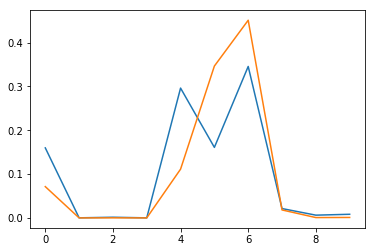

In [ ]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

Class initialised with a true number of signal events $\mu$ and a true number of events $n$. The true number of background events is then computed as $n-mu$. The number of nuisance parameters must also be passed. 

This process includes the analytical effect of the nuisances, and their interdependence, since the augmented batch is passed through the model. This does, however, require that the effect of each nuisance on the input features is accurately parameterised.

Running cycle is:
1. on_train_begin: set alpha as tensor with gradient and `n_alpha+1` elements. Set element zero to $\mu$.
1. for e in #epochs:
    1. for b in #batches:
        1. on_batch_begin: add relevant nuisances to incoming batch of inputs (as implemented in inheriting function)
        1. on_forwards_end:
            1. compute the full hessian of the negative log-likelihood w.r.t alpha (shape systematics included since they're added to the input data and passed through the model)
            1. invert hessian , and set the diagonal element corresponding to $\mu$ as the loss value
        1. on_batch_end: zero gradient of alpha

In [ ]:
#export
class AbsInferno(AbsCallback):
    r'''Attempted reproduction of TF1 & TF2 INFERNO with exact effect of nuisances being passed through model'''
    def __init__(self, n:int, true_mu:float, n_alphas:int=0, float_b:bool=False,
                 alpha_aux:Optional[List[Distribution]]=None, b_aux:Optional[Distribution]=None):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((self.n_alphas+1+self.float_b), requires_grad=True, device=self.wrapper.device)  # Nuisances set to zero (true values)
        with torch.no_grad(): self.alpha[0] = self.true_mu  # POI set to true value
                
    def on_batch_begin(self) -> None:
        self.b_mask = self.wrapper.y.squeeze() == 0
        self.aug_data(self.wrapper.x)
    
    def on_batch_end(self) -> None:
        self.alpha.grad.data.zero_()
    
    @abstractmethod
    def aug_data(self, x:Tensor) -> Tensor:
        r'''Include nuisances in input data. Overide this for specific problem.'''
        pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor, f_b_asimov:Tensor) -> Tensor:
        r'''Compute full hessian at true param values'''
        b_exp = self.true_b+self.alpha[1] if self.float_b else self.true_b
        t_exp  = (self.alpha[0]*f_s)+(b_exp*f_b)
        asimov = (self.true_mu*f_s)+(self.true_b*f_b_asimov)
        nll = -torch.distributions.Poisson(t_exp).log_prob(asimov).sum()
        if self.alpha_aux is not None:  # Constrain shape nuisances
            if len(self.alpha_aux) != self.n_alphas: raise ValueError("Number of auxillary measurements must match the number of nuisance parameters")
            for a,x in zip(self.alpha[1+self.float_b:], self.alpha_aux):  # Constrain shapes
                if x is not None: nll = nll-x.log_prob(a)
        if self.b_aux is not None: nll = nll-self.b_aux.log_prob(b_exp)
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
#         print('hess', h)
#         print('inverse', torch.inverse(h))
#         print('reciprocal', 1/h)
        return torch.inverse(h)[0,0]
        
    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''
        def to_shape(p:Tensor) -> Tensor:
            f = p.sum(0)+1e-7
            return f/f.sum()
        
        f_s = to_shape(self.wrapper.y_pred[~self.b_mask])
        f_b = to_shape(self.wrapper.y_pred[self.b_mask])
        f_b_asimov = to_shape(self.wrapper.model(self.wrapper.x[self.b_mask].detach())) if len(self.alpha) > 1 else f_b
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b, f_b_asimov=f_b_asimov)

In [ ]:
#export
class PaperInferno(AbsInferno):
    r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
    def __init__(self, float_r:bool, float_l:bool, l_init:float=3, n:int=1050, true_mu:int=50, float_b:bool=False,
                 alpha_aux:Optional[List[Distribution]]=None, b_aux:Optional[Distribution]=None):
        super().__init__(n=n, true_mu=true_mu, n_alphas=float_r+float_l, float_b=float_b, alpha_aux=alpha_aux, b_aux=b_aux)
        self.float_r,self.float_l,self.l_init = float_r,float_l,l_init
        
    def aug_data(self, x:Tensor) -> None:
        if self.float_r: x[self.b_mask,0] += self.alpha[1+self.float_b]  # If float_b, alpha_r is element 2 not 1
        if self.float_l: x[self.b_mask,2] *= (self.alpha[-1]+self.l_init)/self.l_init

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [ ]:
%%time
model.fit(10, data=data, opt=partialler(optim.Adam,lr=1e-4), loss=None,
          cbs=[PaperInferno(float_r=True, float_l=True, alpha_aux=[Normal(0,2), Normal(0,2)], float_b=True, b_aux=Normal(1000,100)),
               LossTracker(),SaveBest('weights/best_ie.h5'),EarlyStopping(2)])

1: Train=3069.0915899658203 Valid=1964.8029663085938
2: Train=1232.4312731933594 Valid=1024.2623876953126
3: Train=797.2772576904297 Valid=832.2620751953125
4: Train=720.3076248168945 Valid=800.7880932617187
5: Train=671.3006866455078 Valid=744.1104736328125
6: Train=646.0880499267578 Valid=713.8655749511719
7: Train=631.8734771728516 Valid=689.0419787597656
8: Train=614.3373327636718 Valid=666.7185803222657
9: Train=598.3576831054687 Valid=652.4580541992187
10: Train=582.8880136108398 Valid=624.4385504150391
Loading best model with loss 624.4385504150391
CPU times: user 3min 10s, sys: 45.7 s, total: 3min 56s
Wall time: 3min 13s


In [ ]:
model.save('weights/Inferno_Test_exact_bm2.h5')

In [ ]:
model.load('weights/Inferno_Test_exact_bm2.h5')

# Results

In [ ]:
# export
class InfernoPred(PredHandler):
    r'''Prediction handler for hard assignments'''
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)

## BM 0

In [ ]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [ ]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,3,1.0
1,8,1.0
2,3,1.0
3,8,1.0
4,4,1.0


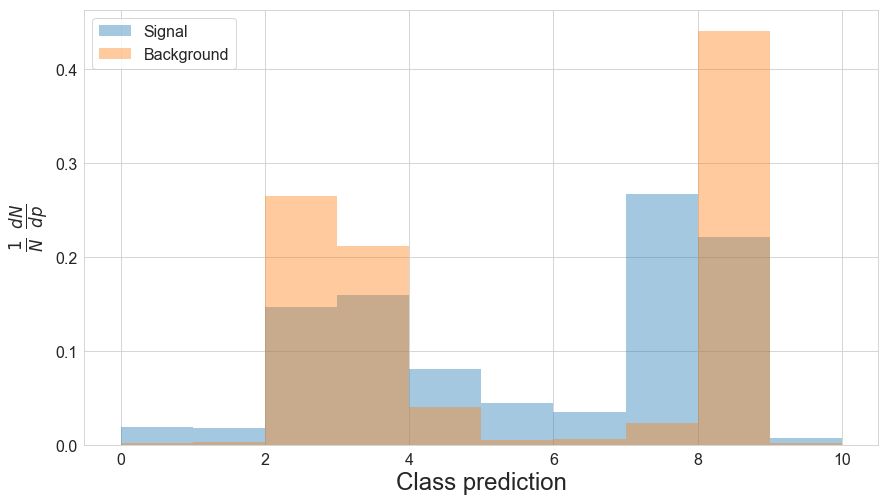

In [ ]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [ ]:
bin_preds(df)

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,3,1.0,3
1,8,1.0,8
2,3,1.0,3
3,8,1.0,8
4,4,1.0,4


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.0000))

In [ ]:
asimov = (50*f_s)+(1000*f_b)

In [ ]:
asimov, asimov.sum()

(tensor([  3.2046,   3.9564, 271.9774, 219.6302,  44.5252,   7.3737,   8.0652,
          36.7415, 452.1741,   2.3517]), tensor(1050.))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([26.85009766, 26.74139023, 26.63626099, 26.53645325, 26.44093704,
       26.34927368, 26.26237488, 26.179142  , 26.10002136, 26.02499008,
       25.95412827, 25.88718796, 25.82397842, 25.76429176, 25.70907211,
       25.65722656, 25.6089592 , 25.56470871, 25.52366257, 25.48630333,
       25.45248413, 25.42173386, 25.39460373, 25.37052917, 25.35029221,
       25.33276367, 25.31900597, 25.30782318, 25.30039978, 25.29590607,
       25.29404068, 25.29571342, 25.3002491 , 25.30782318, 25.31801224,
       25.33153534, 25.34758759, 25.3665638 , 25.38822174, 25.41300583,
       25.44010925, 25.47029495, 25.50267029, 25.53824997, 25.57601738,
       25.61671066, 25.65964127, 25.70544434, 25.75339508, 25.80399513,
       25.85720253, 25.91281128, 25.97074127, 26.03102875, 26.0937767 ,
       26.15869522, 26.22598648, 26.29603195, 26.3678627 , 26.44220734,
       26.51837921])

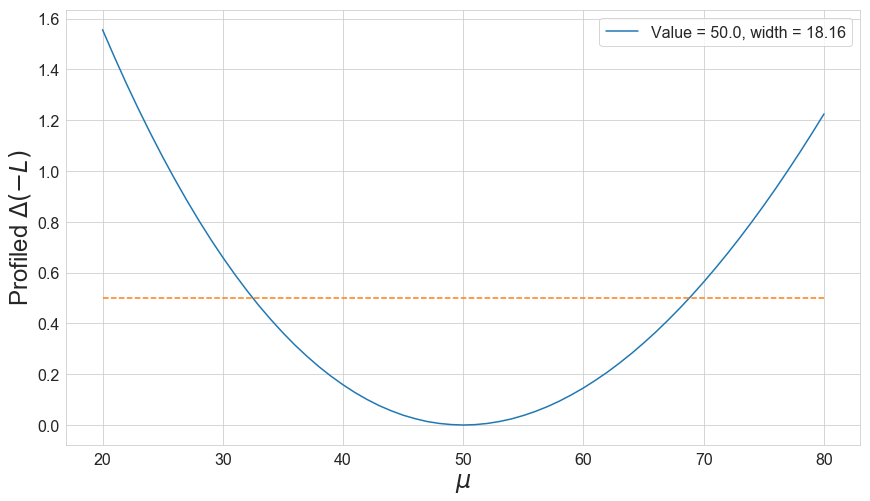

In [ ]:
plot_likelihood(y-y.min())

# Nuisances - via interpolation

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,3,1.0,3,3,3,3,3,3,3,3,3,3,3
1,8,1.0,8,8,8,8,8,8,8,8,8,8,8
2,3,1.0,3,3,3,3,3,3,3,3,3,3,3
3,8,1.0,8,8,8,8,8,8,8,8,8,8,8
4,4,1.0,4,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3,0.0,3,3,3,3,3,3,3,3,3,3,3
999996,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999997,7,0.0,7,7,7,7,7,7,7,7,7,7,7
999998,8,0.0,8,2,2,8,8,8,8,8,8,8,8


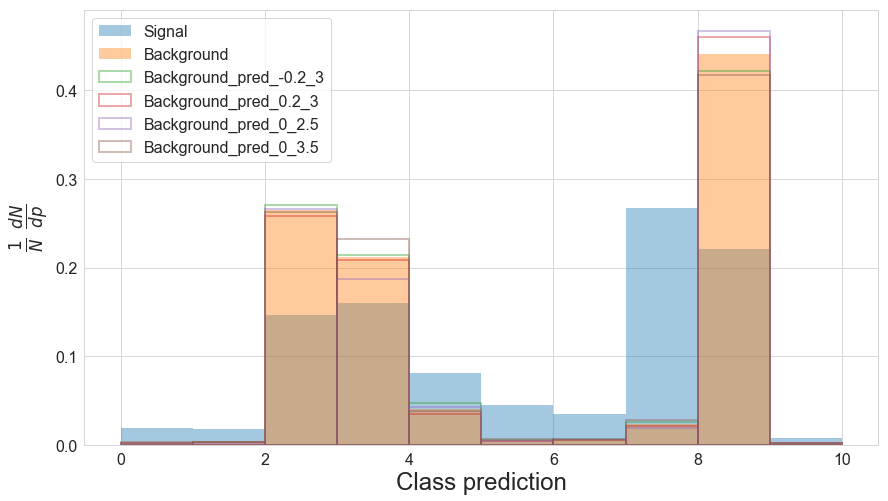

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([0.0016, 0.0027, 0.2721, 0.1902, 0.0497, 0.0044, 0.0075, 0.0219, 0.4482,
        0.0018])
tensor([0.0024, 0.0032, 0.2705, 0.2142, 0.0473, 0.0054, 0.0069, 0.0259, 0.4221,
        0.0021])
tensor([0.0035, 0.0037, 0.2686, 0.2352, 0.0451, 0.0065, 0.0064, 0.0304, 0.3983,
        0.0023])
tensor([0.0014, 0.0025, 0.2663, 0.1876, 0.0428, 0.0041, 0.0069, 0.0194, 0.4673,
        0.0017])
tensor([0.0023, 0.0030, 0.2646, 0.2116, 0.0405, 0.0051, 0.0063, 0.0234, 0.4411,
        0.0020])
tensor([0.0033, 0.0035, 0.2627, 0.2326, 0.0382, 0.0062, 0.0058, 0.0279, 0.4174,
        0.0022])
tensor([0.0013, 0.0024, 0.2599, 0.1841, 0.0369, 0.0036, 0.0061, 0.0173, 0.4866,
        0.0016])
tensor([0.0022, 0.0030, 0.2583, 0.2082, 0.0345, 0.0046, 0.0056, 0.0213, 0.4604,
        0.0019])
tensor([0.0032, 0.0035, 0.2564, 0.2292, 0.0323, 0.0057, 0.0051, 0.0258, 0.4367,
        0.0021])


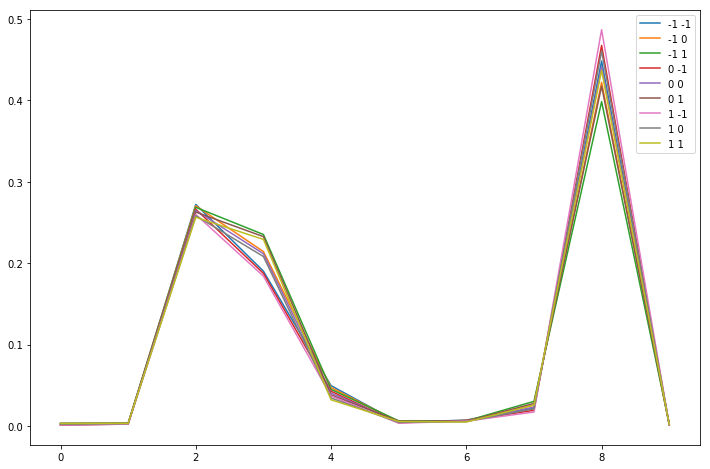

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [ ]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [ ]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [ ]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [ ]:
nll = to_np(nll)

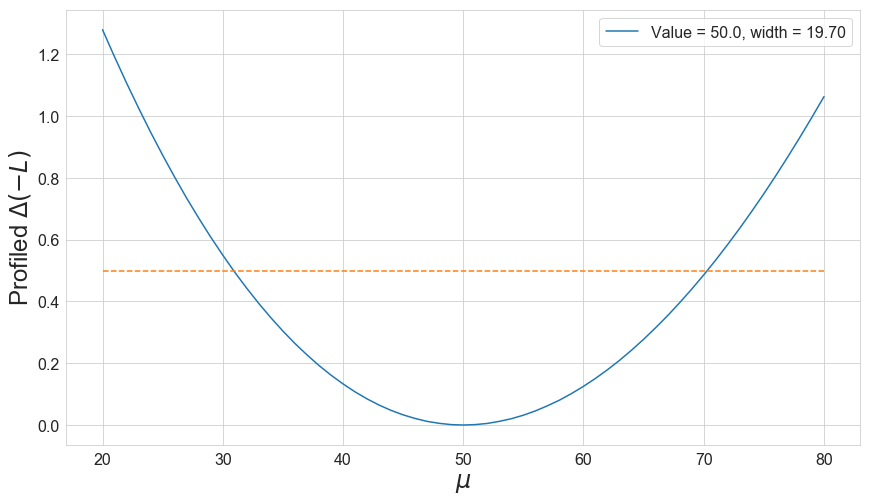

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [ ]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [ ]:
nll = to_np(nll)

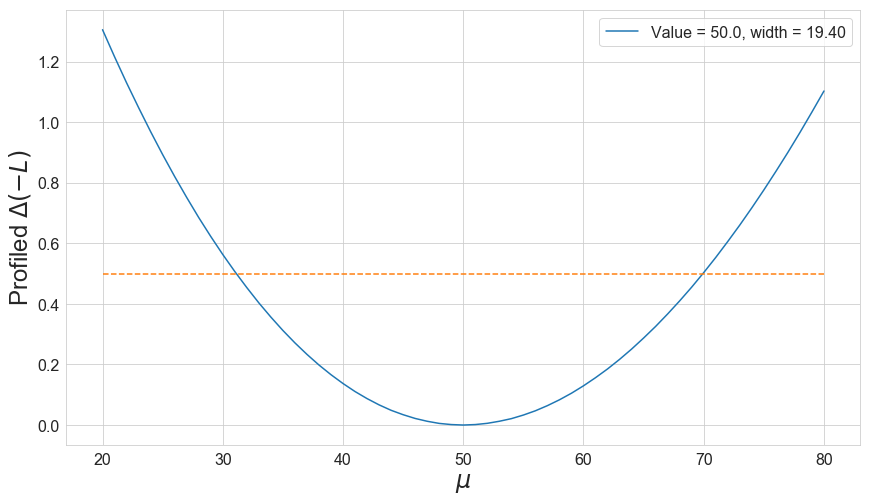

In [ ]:
plot_likelihood(nll-nll.min())

## BM 2

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [ ]:
nll = to_np(nll)

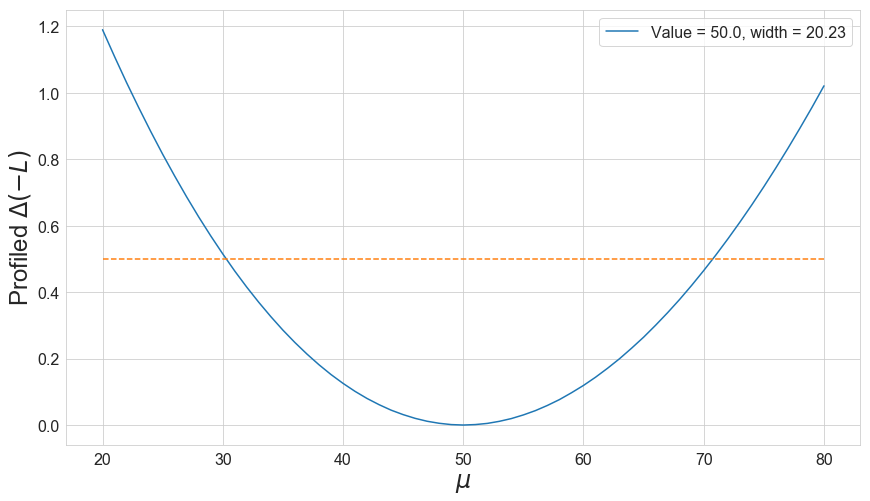

In [ ]:
plot_likelihood(nll-nll.min())

In [ ]:
b_shapes

OrderedDict([('f_b_nom',
              tensor([0.0023, 0.0030, 0.2646, 0.2116, 0.0405, 0.0051, 0.0063, 0.0234, 0.4411,
                      0.0020])),
             ('f_b_up',
              tensor([[0.0022, 0.0030, 0.2583, 0.2082, 0.0345, 0.0046, 0.0056, 0.0213, 0.4604,
                       0.0019],
                      [0.0033, 0.0035, 0.2627, 0.2326, 0.0382, 0.0062, 0.0058, 0.0279, 0.4174,
                       0.0022]])),
             ('f_b_dw',
              tensor([[0.0024, 0.0032, 0.2705, 0.2142, 0.0473, 0.0054, 0.0069, 0.0259, 0.4221,
                       0.0021],
                      [0.0014, 0.0025, 0.2663, 0.1876, 0.0428, 0.0041, 0.0069, 0.0194, 0.4673,
                       0.0017]]))])

In [ ]:
f_s

tensor([0.0189, 0.0183, 0.1469, 0.1599, 0.0812, 0.0447, 0.0348, 0.2670, 0.2208,
        0.0074])

## BM 3

In [ ]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [ ]:
nll = to_np(nll)

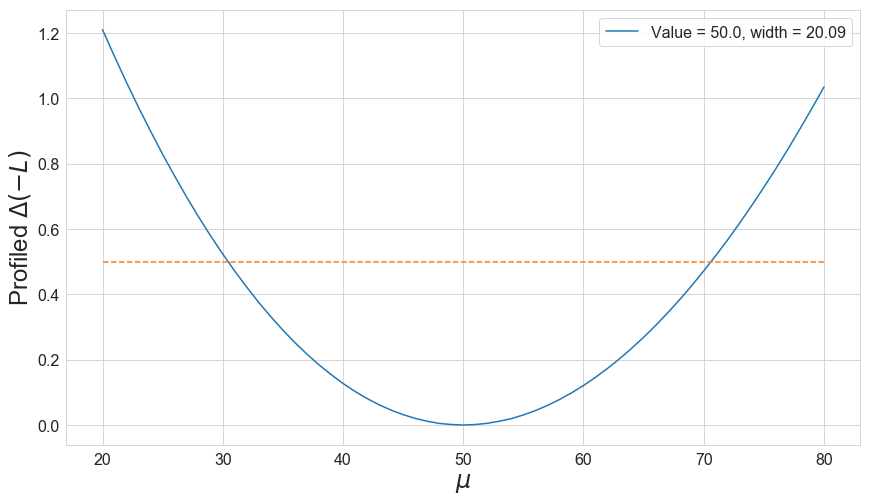

In [ ]:
plot_likelihood(nll-nll.min())

## BM 4

In [ ]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.3212,  0.2135, 26.1562])
Linear regime: Mu 21.0, alpha tensor([-0.3101,  0.2052, 25.2390])
Linear regime: Mu 22.0, alpha tensor([-0.2990,  0.1970, 24.3253])
Linear regime: Mu 23.0, alpha tensor([-0.2879,  0.1889, 23.4149])
Linear regime: Mu 24.0, alpha tensor([-0.2768,  0.1809, 22.5079])
Linear regime: Mu 25.0, alpha tensor([-0.2658,  0.1729, 21.6042])
Linear regime: Mu 26.0, alpha tensor([-0.2548,  0.1651, 20.7038])
Linear regime: Mu 27.0, alpha tensor([-0.2438,  0.1573, 19.8066])
Linear regime: Mu 28.0, alpha tensor([-0.2329,  0.1496, 18.9127])
Linear regime: Mu 29.0, alpha tensor([-0.2220,  0.1420, 18.0220])
Linear regime: Mu 30.0, alpha tensor([-0.2111,  0.1345, 17.1345])
Linear regime: Mu 31.0, alpha tensor([-0.2002,  0.1271, 16.2501])
Linear regime: Mu 32.0, alpha tensor([-0.1894,  0.1197, 15.3687])
Linear regime: Mu 33.0, alpha tensor([-0.1786,  0.1124, 14.4905])
Linear regime: Mu 34.0, alpha tensor([-0.1679,  0.1052, 13.6153])
Linear reg

In [ ]:
nll = to_np(nll)

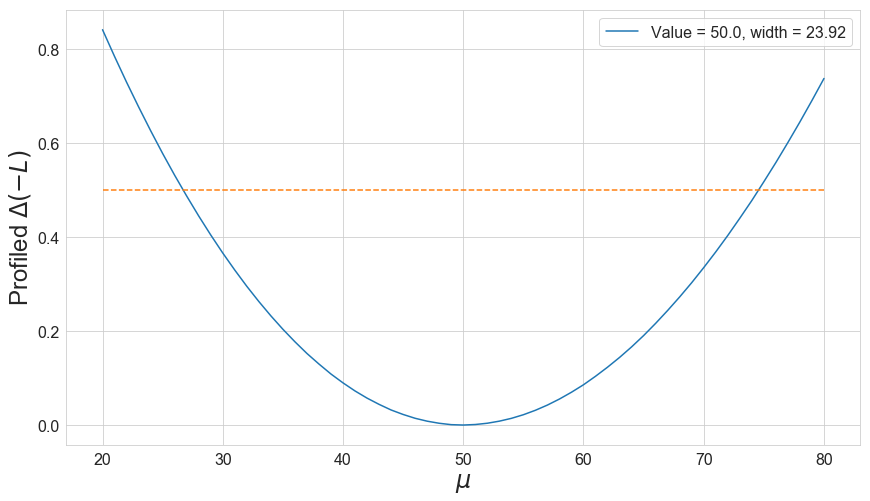

In [ ]:
plot_likelihood(nll-nll.min())